In [112]:
# FILE RENAME SCHEME CODE:
# import os
# #rename physiq filenames:
# folder = "raw_datasets/PHYSIQ_copy/"
# filelabels = []
# for filename in os.listdir(folder):
#     if filename.endswith(".csv"):
#         filelist = filename.split("_")
#         pair = (filelist[1], int(filelist[3]))
#         if pair not in filelabels:
#             filelabels.append(pair)

# # sort by first then sec in pair:
# filelabels.sort(key=lambda x: (x[0], x[1]))

# # how to get index of filelabel (dict):

# print(filelabels)
# print(len(filelabels))
# for filename in os.listdir(folder):
#     if filename.endswith(".csv"):
#         filelist = list(filename.split("_"))
#         print(filelist)
#         filelist[1] = str(filelabels.index((filelist[1], int(filelist[3]))))
#         filelist.pop(3)
#         filelist.pop(3)
#         newname = "_".join(filelist) + '.csv'
#         print(filelist, newname)
#         os.rename(folder+filename, folder+newname)

In [113]:
import os
import numpy as np
import pandas as pd
import torch
            

In [114]:

def generate_data( directory, window_size=75, step_size=32, pick_one=1, range=(0, 6)):
    from utilities import sliding_windows
    sw = sliding_windows(window_size, step_size)
    label_maps = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            if filename.split("_")[1] not in label_maps:
                label_maps.append(filename.split("_")[1])
    print(len(label_maps))
    assert pick_one < len(label_maps), "pick_one is out of range"
    save_data = []
    save_label = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            data = pd.read_csv(directory+filename)
            data_np = data.to_numpy()[:, range[0]:range[1]]
            if pick_one >= 0:
                if filename.split("_")[1] != label_maps[pick_one]:
                    cls = 0
                else:
                    cls = 1
            else:
                cls = label_maps.index(filename.split("_")[1])
            label = np.array([cls] * data_np.shape[0])
            data_windows, label_windows = sw.forward(torch.tensor(data_np), labels=torch.tensor(label))
            save_data.append(data_windows)
            save_label.append(label_windows)
    save_data = torch.cat(save_data)
    save_label = torch.cat(save_label)
    return save_data, save_label
            
            
            

In [115]:
# custom Dataset:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx]), self.label[idx]
        return self.data[idx], self.label[idx]

In [116]:
from utils_loader import MultiEpochsDataLoader
from sklearn.discriminant_analysis import StandardScaler
import torch
from utilities import seed

class StandardTransform(torch.nn.Module):
    def __init__(self, scaler='standard'):
        super(StandardTransform, self).__init__()
        if scaler == 'standard':
            self.scaler = StandardScaler()
        else:
            raise NotImplementedError('Only standard scaler is implemented')
        
    def __call__(self, data):
        data = self.scaler.transform(data)
        return torch.tensor(data)
    
    def fit(self, data):
        n_samples, n_time_steps, n_features = data.shape
        data_reshaped = data.reshape(-1, n_features)  # The shape becomes (n_samples * n_time_steps, n_features)
        self.scaler.fit(data_reshaped)
        print('Fitted with mean: {}, and std: {}'.format(self.scaler.mean_, np.sqrt(self.scaler.var_)))
        return self
    

seed(73054772)
directory = './raw_datasets/SPAR/'

# create train, val, test dataset:
segmented_samples, segmented_labels = generate_data(directory, window_size=100, step_size=50, pick_one=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(segmented_samples, segmented_labels, test_size=0.3, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

d, l = next(iter(train_loader))

7


In [117]:
from segmenter import Segmenter
from utilities import get_device
device = get_device()

MPS is available.


In [118]:
def mean_iou_time_series(pred, gt, num_classes=7):
    """
    Calculate the Mean Intersection over Union (mIoU) for time series data.
    
    Parameters:
        pred (torch.Tensor): Predictions, assumed to be one-hot encoded.
        gt (torch.Tensor): Ground truth labels, assumed to be one-hot encoded.
        num_classes (int): Number of classes in the segmentation task.

    Returns:
        float: Mean IoU for the batch.
    """
    # Initialize variables to store IoU for each class
    iou_list = []

    # Loop through each class
    for cls in range(num_classes):
        pred_inds = pred == cls
        gt_inds = gt == cls

        # Calculate Intersection and Union
        # print(pred_inds.shape, gt_inds.shape)
        intersection = torch.sum(pred_inds & gt_inds, dim=1).float()
        union = torch.sum(pred_inds | gt_inds, dim=1).float()

        # Calculate IoU. Avoid division by zero by adding a small epsilon.
        iou = intersection / (union + 1e-8)

        # Append the mean IoU for this class
        iou_list.append(torch.mean(iou))

    # Calculate the mean IoU across all classes
    mean_iou = torch.mean(torch.stack(iou_list))

    return mean_iou.item()


def mean_iou(preds, labels, num_classes):
    # Flatten the predictions and labels, this comes from the argmax of the one-hot vectors
    preds = preds.view(-1)
    labels = labels.view(-1)

    # Create confusion matrix
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    for i in range(num_classes):
        for j in range(num_classes):
            confusion_matrix[i, j] = torch.sum((preds == i) & (labels == j))

    # Calculate IoU for each class
    ious = []
    for i in range(num_classes):
        true_positive = confusion_matrix[i, i]
        false_positive = confusion_matrix[i, :].sum() - true_positive
        false_negative = confusion_matrix[:, i].sum() - true_positive

        # Avoid division by zero
        union = true_positive + false_positive + false_negative
        if union == 0:
            ious.append(float('nan'))  # No predictions and no labels for this class
        else:
            ious.append(true_positive.float() / union.float())

    # Calculate mean IoU
    ious = torch.tensor(ious)
    mean_iou = torch.nanmean(ious)  # Mean over all classes, ignoring NaNs
    return mean_iou


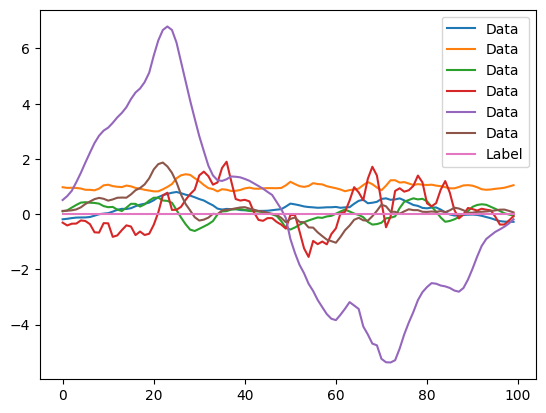

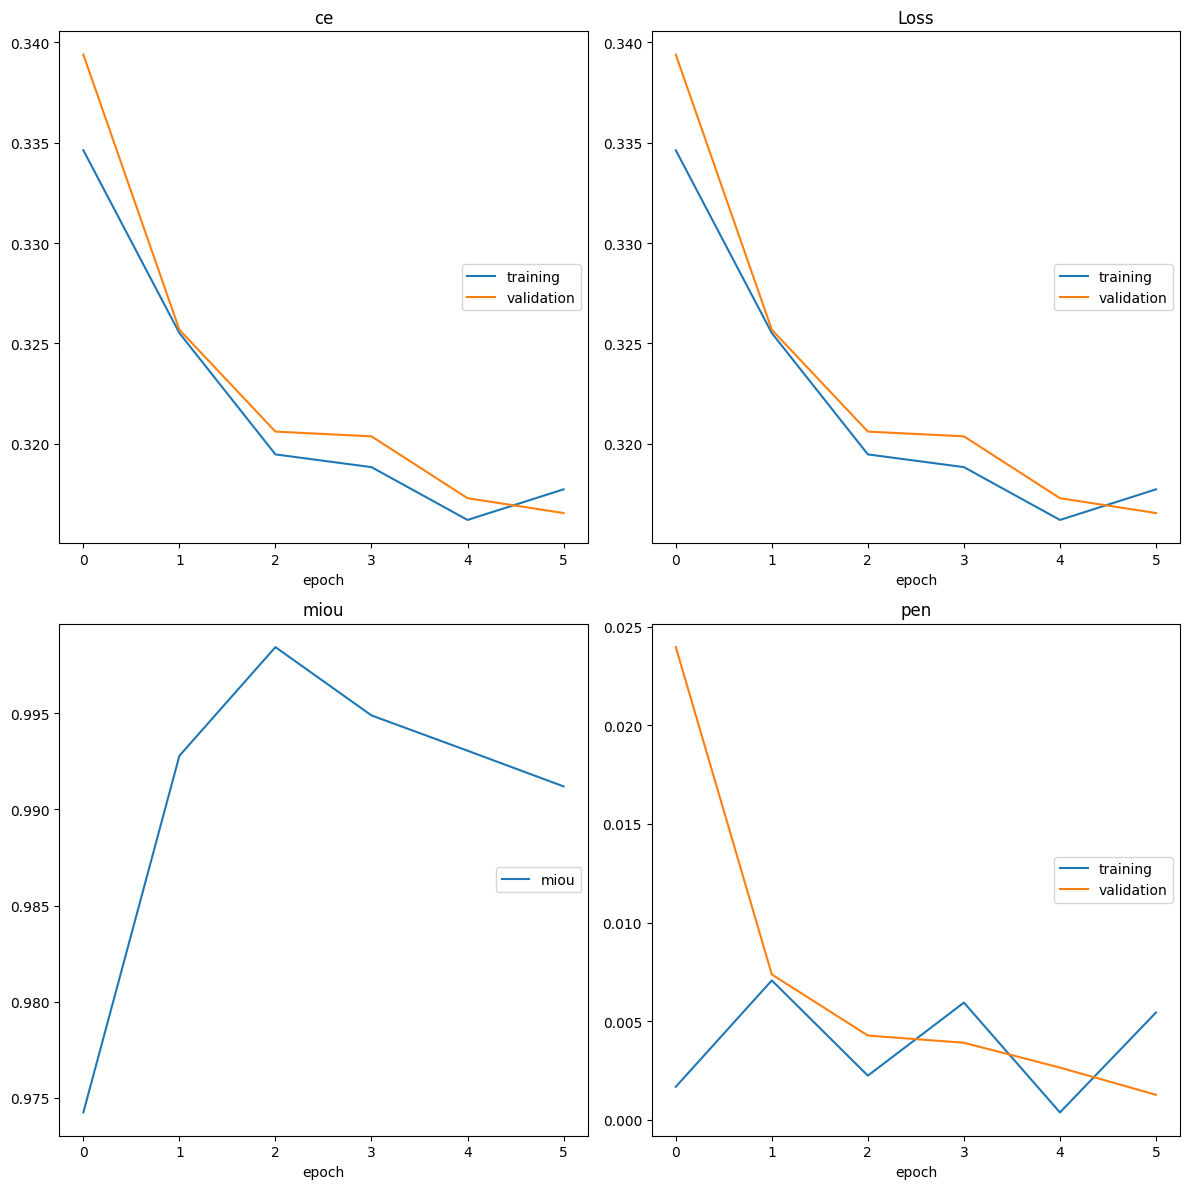

ce
	training         	 (min:    0.316, max:    0.335, cur:    0.318)
	validation       	 (min:    0.317, max:    0.339, cur:    0.317)
Loss
	training         	 (min:    0.316, max:    0.335, cur:    0.318)
	validation       	 (min:    0.317, max:    0.339, cur:    0.317)
miou
	miou             	 (min:    0.974, max:    0.998, cur:    0.991)
pen
	training         	 (min:    0.000, max:    0.007, cur:    0.005)
	validation       	 (min:    0.001, max:    0.024, cur:    0.001)


In [119]:
# Create an instance of the CNN model
from livelossplot import PlotLosses
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from utilities import get_device
num_epochs = 100 
def c_loss(logits):
    probabilities = F.softmax(logits, dim=1)
    one_hot_predictions = torch.argmax(probabilities, dim=1)
    product_prob = torch.prod(probabilities, dim=1)
    changes = torch.abs(one_hot_predictions[:, 1:]*product_prob[:, 1:] - one_hot_predictions[:, :-1]*product_prob[:, :-1])
    penalty = changes.sum(dim=1).float().mean()
    return penalty + 1e-4
def custom_loss(logits, targets, penalty_weight=0.1):
    """
    Custom loss function that penalizes frequent changes in the prediction sequence.
    
    Args:
    - logits: Tensor of shape [N, C, L], where N is batch size, C is number of classes, and L is sequence length.
    - targets: Tensor of shape [N, L] containing class indices for each element in the sequence.
    - penalty_weight: Weight of the penalty term.

    Returns:
    - Total loss with the penalty.
    """

    # Standard cross-entropy loss
    probabilities = F.softmax(logits, dim=1)
    ce_loss = F.cross_entropy(probabilities, targets)

    penalty = c_loss(logits)
    total_loss = ce_loss #penalty * penalty_weight

    return total_loss, ce_loss.item(), penalty.item()

def plotASample(data, label):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)  # Add a new subplot to the figure
    ax.plot(data, label='Data')  # Plot the data
    ax.plot(label, label='Label')  # Plot the label
    ax.legend()  # Add a legend
    fig.canvas.draw()  # Redraw the figure
    plt.plot()


model = Segmenter(embed_dims=64, num_classes=2).to(device)

# Define the loss function and optimizer
criterion = custom_loss #nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.00)
liveloss = PlotLosses()

# Iterate over the training data
logs = {}
# change the plt size:
best_loss = math.inf
counter_i = 0
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Forward pass
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model(images)
        outputs = outputs.permute(0, 2, 1)
        loss, tra_ce, tra_pen = criterion(outputs, labels.long())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # train loss and accuracy check:
        if counter_i % 1000 == 0 and counter_i != 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
            _, predicted = torch.max(outputs.data, 1)
            # total = labels.size(0)
            # correct = (predicted == labels).sum().item()
            # print('Accuracy: {:.2f}%'.format(correct / total * 100))
            logs['loss'] = loss.item()
            logs['ce'] = tra_ce
            logs['pen'] = tra_pen
            # logs['accuracy'] = correct / total * 100
    
            # validation loss and accuracy check:
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.float().to(device)
                labels = labels.to(device)
                outputs = model(images)
                outputs = outputs.permute(0, 2, 1) #view(images.shape[0], 2, -1)
                loss, val_ce, val_pen = criterion(outputs, labels.long())
            logs['val_loss'] = loss.item()
            logs['val_ce'] = val_ce
            logs['val_pen'] = val_pen
            logs['miou'] = mean_iou(model.forward_pred(images), labels.long(), num_classes=7)
            if best_loss > loss.item():
                best_loss = loss.item()
                torch.save(model.state_dict(), './saved_model/best_transformer_spar.pth')
            pred = torch.argmax(torch.softmax(outputs[0], dim=0), dim=0).detach().cpu().numpy()
            plotASample(images[0].detach().cpu().numpy(), pred)
            liveloss.update(logs)
            liveloss.send()
            # logs['val_accuracy'] = correct / total * 100
        counter_i += 1


In [120]:
import time
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import torch


model = Segmenter(embed_dims=64, num_classes=2).to(device)
model.load_state_dict(torch.load('./saved_model/best_transformer_spar.pth', map_location=device))

model.eval()
miou, total = 0, 0
with torch.no_grad():
    for data, label in test_loader:
        data = data.float().to(device)
        label = label.squeeze().long().to(device)
        output = model.forward_pred(data)
        # print(output.shape, label.shape)
        # print(output[0], label[0])
        miou += mean_iou(output, label, 7)
        total += 1
        
        # print('output', output)])
        # plt.plot(data[0].view(-1, 6).cpu().numpy(), color='black')
        # plt.plot(output[0].view(-1).detach().squeeze().cpu().numpy(), color='green')
        # plt.plot(label[0].view(-1).cpu().numpy(), color='red')
        # plt.show()
        # # wait for 1 sec:
        # time.sleep(1)
        # erase the output:
        # clear_output(wait=True)

print('mIoU coefficient:', miou / total)

mIoU coefficient: tensor(0.9901)


# Attempt to do FSL on segmentation, we treating each embedding in t as a proabbilities distribution

In [121]:
# few show learning on a new dataset:
directory = './raw_datasets/SPAR/'

# create segmented samples
segmented_samples, segmented_labels = generate_data(directory, window_size=100, step_size=50, pick_one=1)
proc_segmented_samples = []
proc_segmented_labels =[]
print(len(segmented_samples), len(segmented_labels))
for ss, sl in zip(segmented_samples, segmented_labels):
    if sl[0] <= 6:
        proc_segmented_samples.append(ss)
        proc_segmented_labels.append(sl)
print(len(proc_segmented_samples), len(proc_segmented_labels))

# split the dataset:
X_train, X_test, y_train, y_test = train_test_split(proc_segmented_samples, proc_segmented_labels, test_size=0.3, random_state=42, shuffle=True)


7
11767 11767
11767 11767


In [182]:
# get samples for each class:
samples = []
labels = []
label_flag = [0]*7
for s, l in zip(X_train, y_train):
    if label_flag[l[0]] < 1 and l[0] != 0:
        samples.append(s)
        labels.append(l)
        label_flag[l[0]] += 1
    else:
        continue
samples = torch.stack(samples)
labels = torch.stack(labels)



test_samples = []
test_labels = []
label_flag = [0]*7
for s, l in zip(X_test, y_test):
    if label_flag[l[0]] < 1 and l[0] != 0:
        test_samples.append(s)
        test_labels.append(l)
        label_flag[l[0]] += 1
    else:
        continue
test_samples = torch.stack(test_samples)
test_labels = torch.stack(test_labels)
samples.shape, labels.shape, test_samples.shape, test_labels.shape

(torch.Size([1, 100, 6]),
 torch.Size([1, 100]),
 torch.Size([1, 100, 6]),
 torch.Size([1, 100]))

In [184]:
model = Segmenter(embed_dims=64, num_classes=2).to(device)
model.load_state_dict(torch.load('./saved_model/best_transformer_spar.pth', map_location=device))
model.eval()
patch, cls_seg_feat = model.get_embedding(samples.float().to(device))
mask = model(samples.float().to(device))
patch_0 = patch[0].squeeze().detach().cpu().numpy()
patch.shape, cls_seg_feat.shape, mask.shape

(torch.Size([1, 100, 64]), torch.Size([1, 2, 64]), torch.Size([1, 100, 2]))

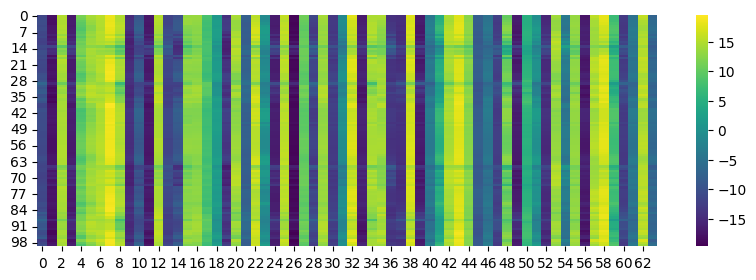

In [185]:
# use the patch embedding of the first sample to visualize the attention:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# plot the cls_seg_feat:
plt.figure(figsize=(10, 3))
sns.heatmap(patch_0, cmap='viridis')
plt.show()



In [186]:
#TODO: not finished yet on how to get this done: getting the distribution of the same labels for all the samples, 
# then compare against query sample so that we can use it as a transductive method to predict the label of the query sample at t.

# placeholder = []
# for _ in range(7):
#     placeholder.append([])
    
# for each_sample, each_label in zip(patch, labels):
#     for i in range(each_label.shape[0]):
#         placeholder[each_label[i]].append(each_sample[i].detach().cpu().numpy())
    

# for i in range(7):
#     placeholder[i] = np.array(placeholder[i])
#     print(placeholder[i].shape)
#     plt.plot(placeholder[i].mean(axis=0), label=str(i))
model.eval()
patch_query, cls_seg_feat = model.get_embedding(test_samples.float().to(device))
mask = model(samples.float().to(device))



In [206]:
from collections import OrderedDict


class time_FewShotSeg(nn.Module):
    """
    Fewshot Segmentation model

    Args:
        in_channels:
            number of input channels
        pretrained_path:
            path of the model for initialization
        cfg:
            model configurations
    """
    def __init__(self, in_channels=6, pretrained_path=None, cfg=None):
        super().__init__()
        self.pretrained_path = pretrained_path
        self.config = cfg or {'align': True}
        

        # Encoder
        self.encoder = model.to('cpu')

    def forward(self, supp_imgs, fore_mask, back_mask, qry_imgs):
        """
        Args:
            supp_imgs: support images
                way x shot x [B x 6 x 100], list of lists of tensors
            fore_mask: foreground masks for support images
                way x shot x [B x 100], list of lists of tensors
            back_mask: background masks for support images
                way x shot x [B x 100], list of lists of tensors
            qry_imgs: query images
                N x [B x 6 x 100], list of tensors
        """
        n_ways = len(supp_imgs)
        n_shots = len(supp_imgs[0])
        n_queries = len(qry_imgs)
        batch_size = supp_imgs[0][0].shape[0]
        img_size = supp_imgs[0][0].shape[-1:]
        assert type(supp_imgs) == list and type(supp_imgs[0]) == list and type(supp_imgs[0][0]) == torch.Tensor
        print('n_ways:', n_ways, 'n_shots:', n_shots, 'n_queries:', n_queries, 'batch_size:', batch_size, 'img_size:', img_size)
        ###### Extract features ######
        print('supp_imgs shape:', supp_imgs[0][0].shape)
        imgs_concat = torch.cat([torch.cat(way, dim=0) for way in supp_imgs]
                                + [torch.cat(qry_imgs, dim=0),], dim=0)
        print('after concat', imgs_concat.shape, 'which is (Wa*Sh + N) x B x 6 x 100, Wa =', n_ways, 'Sh =', n_shots, 'N =', n_queries, 'B =', batch_size)
        print(imgs_concat.shape)
        temp = self.encoder.get_embedding(imgs_concat.transpose(1, 2).float())
        img_fts = temp[0]
        print('after go through encoder', img_fts.shape)
        fts_size = img_fts.shape[-1:] # this is the length, aka 100 (Time series length)
        print('fts_size:', fts_size)
        
        supp_fts = img_fts[:n_ways * n_shots * batch_size].view(
            n_ways, n_shots, batch_size, -1, *fts_size)
        print('supp_fts shape:', supp_fts.shape)
        qry_fts = img_fts[n_ways * n_shots * batch_size:].view(
            n_queries, batch_size, -1, *fts_size)
        print('qry_fts shape:', qry_fts.shape)
        fore_mask = torch.stack([torch.stack(way, dim=0)
                                 for way in fore_mask], dim=0)
        print('fore_mask shape:', fore_mask.shape)
        back_mask = torch.stack([torch.stack(way, dim=0)
                                 for way in back_mask], dim=0)
        print('back_mask shape:', back_mask.shape)
        

        ###### Compute loss ######
        align_loss = 0
        outputs = []
        for epi in range(batch_size):
            ###### Extract prototype ######
            supp_fg_fts = [[self.getFeatures(supp_fts[way, shot, [epi]],
                                             fore_mask[way, shot, [epi]])
                            for shot in range(n_shots)] for way in range(n_ways)] # 1 x C (channel embedding)
            supp_bg_fts = [[self.getFeatures(supp_fts[way, shot, [epi]],
                                             back_mask[way, shot, [epi]])
                            for shot in range(n_shots)] for way in range(n_ways)] # 1 x C (channel embedding)
            ###### Obtain the prototypes######
            fg_prototypes, bg_prototype = self.getPrototype(supp_fg_fts, supp_bg_fts) 
            print('fg_prototypes shape:', len(fg_prototypes), fg_prototypes[0].shape)
            print('bg_prototype shape:', bg_prototype.shape)

            ###### Compute the distance ######
            prototypes = [bg_prototype,] + fg_prototypes
            print('prototypes shape:', len(prototypes), prototypes[0].shape)
            dist = [self.calDist(qry_fts[:, epi], prototype) for prototype in prototypes]
            print('dist shape:', len(dist), dist[0].shape)
            pred = torch.stack(dist, dim=1)
            print('pred shape:', pred.shape)
            outputs.append(F.interpolate(pred, size=img_size, mode='linear'))
            print('upsampling', F.interpolate(pred, size=img_size, mode='linear').shape)
            print('outputs shape:', len(outputs), outputs[0].shape)

            ###### Prototype alignment loss ######
            if self.config['align']:
                align_loss_epi = self.alignLoss(qry_fts[:, epi], pred, supp_fts[:, :, epi],
                                                fore_mask[:, :, epi], back_mask[:, :, epi])
                align_loss += align_loss_epi
        output = torch.stack(outputs, dim=1)  # N x B x (1 + Wa) x H x W
        output = output.view(-1, *output.shape[2:])
        print(output.shape)
        return output, align_loss / batch_size
        
    def calDist(self, fts, prototype, scaler=20):
        """
        Calculate the distance between features and prototypes

        Args:
            fts: input features
                expect shape: N x C x H
            prototype: prototype of one semantic class
                expect shape: 1 x C
        """
        print('CALDIST fts shape:', fts.shape, 'prototype shape:', prototype.shape)
        dist = F.cosine_similarity(fts, prototype[..., None], dim=1) * scaler
        return dist
        
    def getFeatures(self, fts, mask):
        """
        Extract foreground and background features via masked average pooling

        Args:
            fts: input features, expect shape: 1 x C x H'
            mask: binary mask, expect shape: 1 x H
            
        originally: 
        fts = F.interpolate(fts, size=mask.shape[-2:], mode='bilinear')
        # IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)
        masked_fts = torch.sum(fts * mask[None, ...], dim=(2, 3)) \
            / (mask[None, ...].sum(dim=(2)) + 1e-5)
        return masked_fts
        """
        # interpolate on three dim data:
        fts = F.interpolate(fts, size=mask.shape[-1:], mode='linear')
        # print(mask.shape[-1:])
        # fts = fts
        # print(fts.shape)
        # print('fts shape:', fts.shape)x
        masked_fts = torch.sum(fts * mask[None, ...], dim=(2)) \
            / (mask[None, ...].sum(dim=(2)) + 1e-5)
        return masked_fts
        
    def getPrototype(self, fg_fts, bg_fts):
        """
        Average the features to obtain the prototype

        Args:
            fg_fts: lists of list of foreground features for each way/shot
                expect shape: Wa x Sh x [1 x C]
            bg_fts: lists of list of background features for each way/shot
                expect shape: Wa x Sh x [1 x C]
        """
        n_ways, n_shots = len(fg_fts), len(fg_fts[0])
        fg_prototypes = [sum(way) / n_shots for way in fg_fts]
        bg_prototype = sum([sum(way) / n_shots for way in bg_fts]) / n_ways
        return fg_prototypes, bg_prototype
    
    def alignLoss(self, qry_fts, pred, supp_fts, fore_mask, back_mask):
        """
        Compute the loss for the prototype alignment branch

        Args:
            qry_fts: embedding features for query images
                expect shape: N x C x H'
            pred: predicted segmentation score
                expect shape: N x (1 + Wa) x H
            supp_fts: embedding features for support images
                expect shape: Wa x Sh x C x H'
            fore_mask: foreground masks for support images
                expect shape: way x shot x H
            back_mask: background masks for support images
                expect shape: way x shot x H
        """
        n_ways, n_shots = len(fore_mask), len(fore_mask[0])

        # Mask and get query prototype
        pred_mask = pred.argmax(dim=1, keepdim=True)
        binary_masks = [pred_mask == i for i in range(1 + n_ways)]
        skip_ways = [i for i in range(n_ways) if binary_masks[i + 1].sum() == 0]
        pred_mask = torch.stack(binary_masks, dim=1).float()
        # print(pred_mask.shape, qry_fts.shape, (qry_fts.unsqueeze(1) * pred_mask).shape)
        qry_prototypes = torch.sum(qry_fts.unsqueeze(1) * pred_mask, dim=(0, 3))
        qry_prototypes = qry_prototypes / (pred_mask.sum((0, 3)) + 1e-5)
        # print('qry_prototypes shape:', qry_prototypes.shape)
        # Compute the support loss
        loss = 0
        for way in range(n_ways):
            if way in skip_ways:
                continue
            # Get the query prototypes
            prototypes = [qry_prototypes[[0]], qry_prototypes[[way + 1]]]
            for shot in range(n_shots):
                img_fts = supp_fts[way, [shot]]
                supp_dist = [self.calDist(img_fts, prototype) for prototype in prototypes]
                supp_pred = torch.stack(supp_dist, dim=1)
                supp_pred = F.interpolate(supp_pred, size=fore_mask.shape[-1],
                                          mode='linear')
                # Construct the support Ground-Truth segmentation
                supp_label = torch.full_like(fore_mask[way, shot], -1,
                                             device=img_fts.device).long() # not fore or back?
                supp_label[fore_mask[way, shot] == 1] = 1
                supp_label[back_mask[way, shot] == 1] = 0
                # Compute Loss
                loss = loss + F.cross_entropy(
                    supp_pred, supp_label[None, ...], ignore_index=-1) / n_shots / n_ways
        return loss

In [207]:
fss = time_FewShotSeg()
# make the labels as two variables of foreground and background:
fore_mask = []
back_mask = []
for l in test_labels:
    fore_mask.append([l.unsqueeze(0)])
    back_mask.append([(1-l).unsqueeze(0)])
# fore_mask = torch.stack(fore_mask)
# back_mask = torch.stack(back_mask)
# print(fore_mask.shape, back_mask.shape)
samples_inpt = []
for i in samples:
    samples_inpt.append([i.transpose(0, 1).unsqueeze(0)])
samples_test = []
for i in test_samples:
    samples_test.append(i.transpose(0, 1).unsqueeze(0))
    
seg, loss = fss(supp_imgs=samples_inpt, fore_mask=fore_mask, back_mask=back_mask, qry_imgs=samples_test)

n_ways: 1 n_shots: 1 n_queries: 1 batch_size: 1 img_size: torch.Size([100])
supp_imgs shape: torch.Size([1, 6, 100])
after concat torch.Size([2, 6, 100]) which is (Wa*Sh + N) x B x 6 x 100, Wa = 1 Sh = 1 N = 1 B = 1
torch.Size([2, 6, 100])
after go through encoder torch.Size([2, 100, 64])
fts_size: torch.Size([64])
supp_fts shape: torch.Size([1, 1, 1, 100, 64])
qry_fts shape: torch.Size([1, 1, 100, 64])
fore_mask shape: torch.Size([1, 1, 1, 100])
back_mask shape: torch.Size([1, 1, 1, 100])
fg_prototypes shape: 1 torch.Size([1, 100])
bg_prototype shape: torch.Size([1, 100])
prototypes shape: 2 torch.Size([1, 100])
CALDIST fts shape: torch.Size([1, 100, 64]) prototype shape: torch.Size([1, 100])
CALDIST fts shape: torch.Size([1, 100, 64]) prototype shape: torch.Size([1, 100])
dist shape: 2 torch.Size([1, 64])
pred shape: torch.Size([1, 2, 64])
upsampling torch.Size([1, 2, 100])
outputs shape: 1 torch.Size([1, 2, 100])
CALDIST fts shape: torch.Size([1, 100, 64]) prototype shape: torch.Siz

In [208]:
seg.shape, test_samples.shape, test_labels.shape, seg.argmax(dim=1).cpu().shape

(torch.Size([1, 2, 100]),
 torch.Size([1, 100, 6]),
 torch.Size([1, 100]),
 torch.Size([1, 100]))

tensor(0.2750)

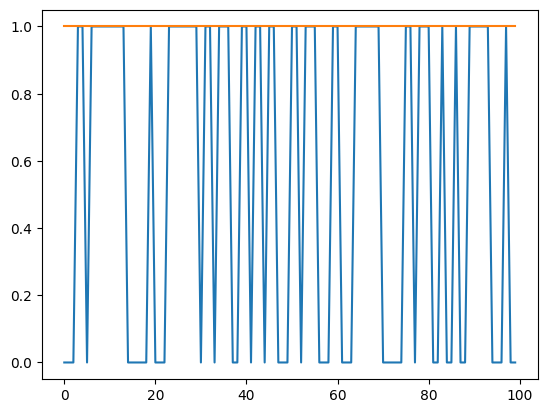

In [191]:
plt.plot(seg.argmax(dim=1).cpu().detach().numpy()[0].squeeze())
plt.plot(test_labels[0].cpu().detach().numpy().squeeze())

mean_iou(seg.argmax(dim=1), test_labels, 2)